# Desarrollo de modelos

Este notebook se utiliza para el desarrollo de modelos de clasificación para el problema seleccionado. 
Está organizado en las siguientes secciones:

1. Carga del dataset
2. Análisis Exploratorio de Datos
3. Preprocesamiento
4. Ingeniería de Features
5. Desarrollo y Entrenamiento de Modelos
6. Comparación de resultados y conclusiones

## Descripción del problema

Dado un [dataset de operaciones con tarjetas de crédito (fuente:Kaggle)](https://www.kaggle.com/mlg-ulb/creditcardfraud) interesa etiquetar aquellas sospechosas que puedan indicar fraude.
El dataset contiene:
- **Información temporal**: Los segundos transcurridos desde la primer operación del dataset.
- **Features v1-v28**: probablemente obtenidas con PCA para proteger la identidad de los usuarios y capturar aquellas de más relevancia para el problema.
- **Monto de la operación**
- **Resultado de la clasificación**: 0=No fraude, 1=Fraude.


### Alcance y Limitaciones

- Si bien está disponible la información temporal, los modelos estudiados tratarán el problema como si se tratara de eventos aislados.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import joblib

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

TMP_PATH = "./tmp/" # Path temporal usado para imágenes generadas, archivos intermedios, etc.
MODELS_PATH = "/models/"

## Procedimiento

### 1. Carga del dataset

Se puede cargar el dataset desde un archivo o desde ElasticSearch. Para este trabajo se propone el segundo método.

#### Opción 1) De archivo CSV.

In [2]:
DATASET_FILENAME_PATH = "/data/credit_fraud/creditcard.csv"

def load_credit_fraud_from_csv(path=DATASET_FILENAME_PATH):
    col_names = [ "time" ]
    col_names.extend(["v{}".format(x) for x in range(1,28)])
    col_names.append( "amount" )
    col_names.append( "class" )
    return pd.read_csv(DATASET_FILENAME_PATH,skiprows=1,index_col=0, names=col_names)

#### Opción 2) De ElasticSearch.

In [3]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

ELASTICSEARCH_HOST = 'elasticsearch'
ELASTICSEARCH_PORT = 9200
ELASTICSEARCH_DATASET_INDEX = 'creditfraud-1'

def load_credit_fraud_from_elasticsearch(host=ELASTICSEARCH_HOST,port=ELASTICSEARCH_PORT, 
                                         index=ELASTICSEARCH_DATASET_INDEX):
    es = Elasticsearch(f"http://{ELASTICSEARCH_HOST}:{ELASTICSEARCH_PORT}/")
    s = Search(using=es, index=index)
    return pd.DataFrame([hit.to_dict() for hit in s.scan()]).astype(float)

In [4]:
#df = load_credit_fraud_from_csv()
df = load_credit_fraud_from_elasticsearch()

### 2. Análisis Exploratorio de Datos

In [5]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,class,row_id
0,1.602720e+09,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0,0.0
1,1.602720e+09,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0,1.0
2,1.602720e+09,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0,2.0
3,1.602720e+09,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0,3.0
4,1.602720e+09,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0,4.0


Vista de tipos de datos de columnas (nota: los campos de interés ya han sido convertidos a Float previamente).

In [6]:
df.dtypes

time      float64
v1        float64
v2        float64
v3        float64
v4        float64
v5        float64
v6        float64
v7        float64
v8        float64
v9        float64
v10       float64
v11       float64
v12       float64
v13       float64
v14       float64
v15       float64
v16       float64
v17       float64
v18       float64
v19       float64
v20       float64
v21       float64
v22       float64
v23       float64
v24       float64
v25       float64
v26       float64
v27       float64
v28       float64
amount    float64
class     float64
row_id    float64
dtype: object

In [7]:
df.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,class,row_id
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,1.602815e+09,2.923228e-15,2.941874e-16,-7.913248e-15,1.894555e-15,9.829743e-16,1.470984e-15,-1.045995e-15,-2.445951e-16,-1.869256e-15,...,-4.302640e-16,6.094655e-17,4.444939e-15,1.606285e-15,1.737425e-15,-3.925610e-16,-1.152161e-16,88.349619,0.001727,142403.000000
std,4.748815e+04,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,82216.843396
min,1.602720e+09,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,0.000000
25%,1.602774e+09,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,71201.500000
50%,1.602805e+09,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,142403.000000
75%,1.602859e+09,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,213604.500000
max,1.602893e+09,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,284806.000000


Distribución de valores. 

In [8]:
df['class'].value_counts()

0.0    284315
1.0       492
Name: class, dtype: int64

### 2. Preprocesamiento de dataset

#### 2.1 Manejo de datos inválidos

Este dataset, al igual que muchos descargados de Kaggle, ya fue previamente procesado y no contiene filas con NaNs.

In [9]:
ds_with_nans = df.loc[df.isna().sum(axis=1)>=1,:]
ds_without_nans = df.loc[df.isna().sum(axis=1)==0,:]
print("Filas con NaNs:{}".format(ds_with_nans.shape[0]))
print("Filas sin NaNs: {}".format(ds_without_nans.shape[0]))

Filas con NaNs:0
Filas sin NaNs: 284807


#### 2.2 Manejo de datos imbalanceados.

Como se observó en el análisis exploratorio inicial, los datos están fuertemente desbalanceados en favor de los casos no fraudulentos.
Aquí se pueden adoptar distintas estrategias:
1. **Upsampling**: aumentar la cantidad de muestras de la clase minoritaria (agregando muestras reales o artificiales).
2. **Downsampling**: reducir la cantidad de muestras de la clase mayoritaria.
3. **Cambiar la métrica de evaluación**: no hacer nada en la preparación del dataset, y elegir una métrica de performance adecuada para este escenario.

Se procederá con la opción 2.

In [10]:
from sklearn.utils import resample

In [11]:
df_majority = df[df['class']==0]
df_minority = df[df['class']==1]

In [12]:
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=123)

In [13]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['class'].value_counts()

1.0    492
0.0    492
Name: class, dtype: int64

In [14]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [15]:
non_feature_cols = ['time','row_id','class']
feature_cols = [x for x in df.columns if x not in non_feature_cols]
feature_cols

['v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'v28',
 'amount']

In [16]:
X = df_downsampled[feature_cols]
y = df_downsampled['class']

In [17]:
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=1)

### 3. Ingeniería de features

#### 3.1 Análisis por correlación
Plot-box de las variables mas correlacionadas con la salida.

In [18]:
exclude_corr_cols = ['time','row_id']
corr_cols = [x for x in df_downsampled.columns if x not in exclude_corr_cols]

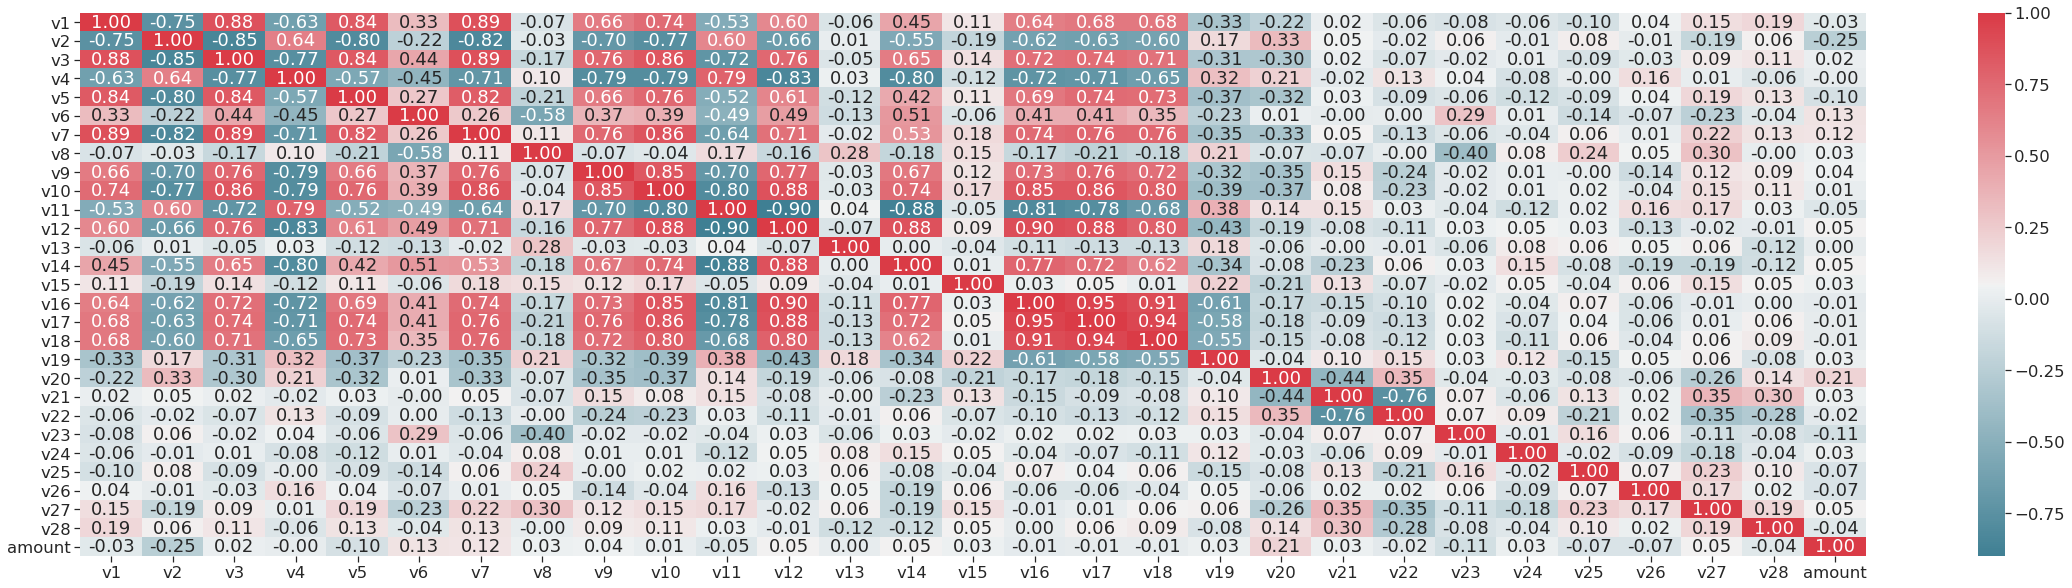

In [19]:
fig, ax1 = plt.subplots(1, figsize=(40,10))
corr = X_train.corr() # Todo combinar con Y_train
sns.heatmap(corr, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

#### 3.2 Análisis por Random Forest


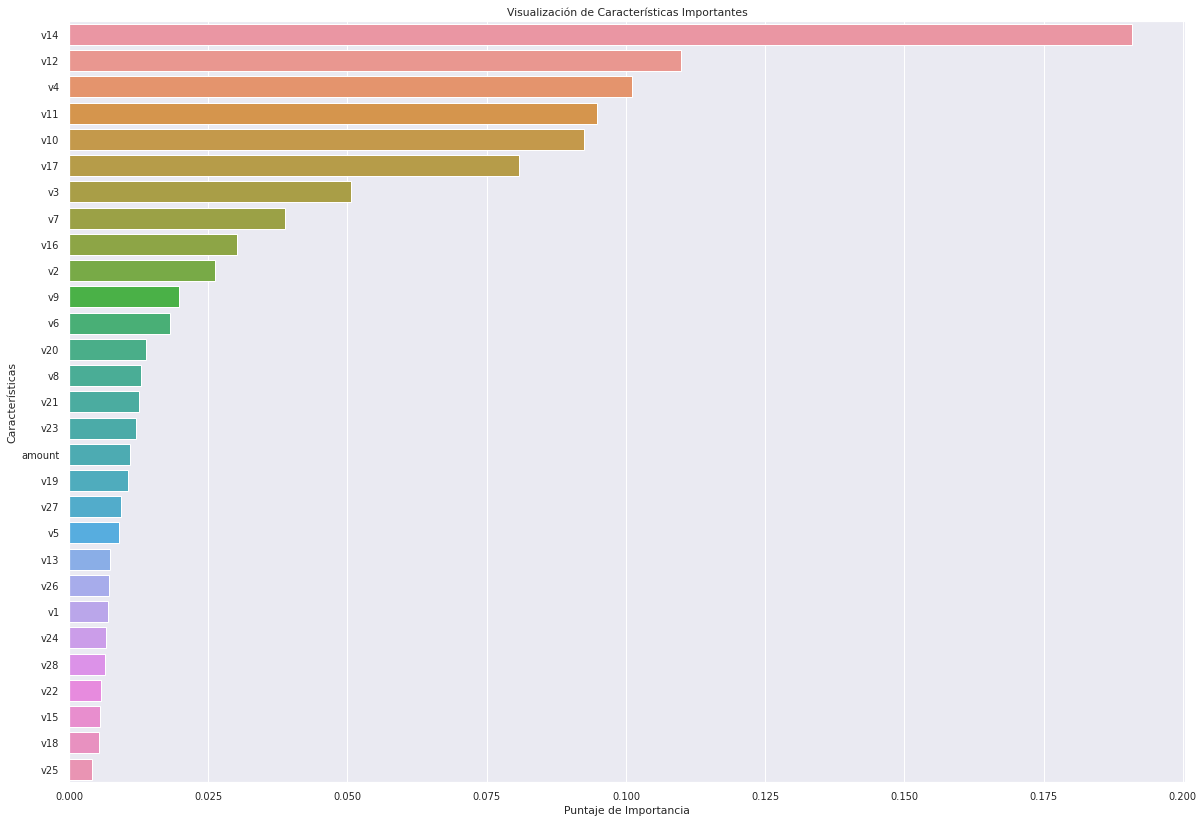

In [20]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train,y_train)

feature_imp = pd.Series(clf.feature_importances_,index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(20,14))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Puntaje de Importancia')
plt.ylabel('Características')
plt.title("Visualización de Características Importantes")
plt.show()

### 4. Entrenamiento de modelos

Criterio de evaluación. Para todos los modelos se obtienen métricas relevantes para la clasificación binaria:
- Accuracy.
- Precision.
- Recall
- Matriz de Confusión
- Curva ROC

In [21]:
from sklearn.metrics import plot_confusion_matrix

def model_evaluation_report(model,y_test,y_pred,y_pred_prob):
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    
    #fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 3]))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1])
    
    plt.figure()    
    plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
    plt.title("Confusion Matrix")
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta real')
    plt.show()
    
    plt.figure()
    plt.plot(fpr, tpr)    
    plt.title("Curva ROC")
    plt.xlabel('Tasa de falsos positivos (1 - Especificidad)')
    plt.ylabel('Tasa de positivos (Sensibilidad)')
    plt.show()

In [22]:
def save_model(model, model_filename):    
    joblib.dump(model, MODELS_PATH+model_filename)

#### 4.1 Árboles de decisión

In [23]:
from sklearn.tree import DecisionTreeClassifier
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

##### 4.1 Modelo 1, sin poda 

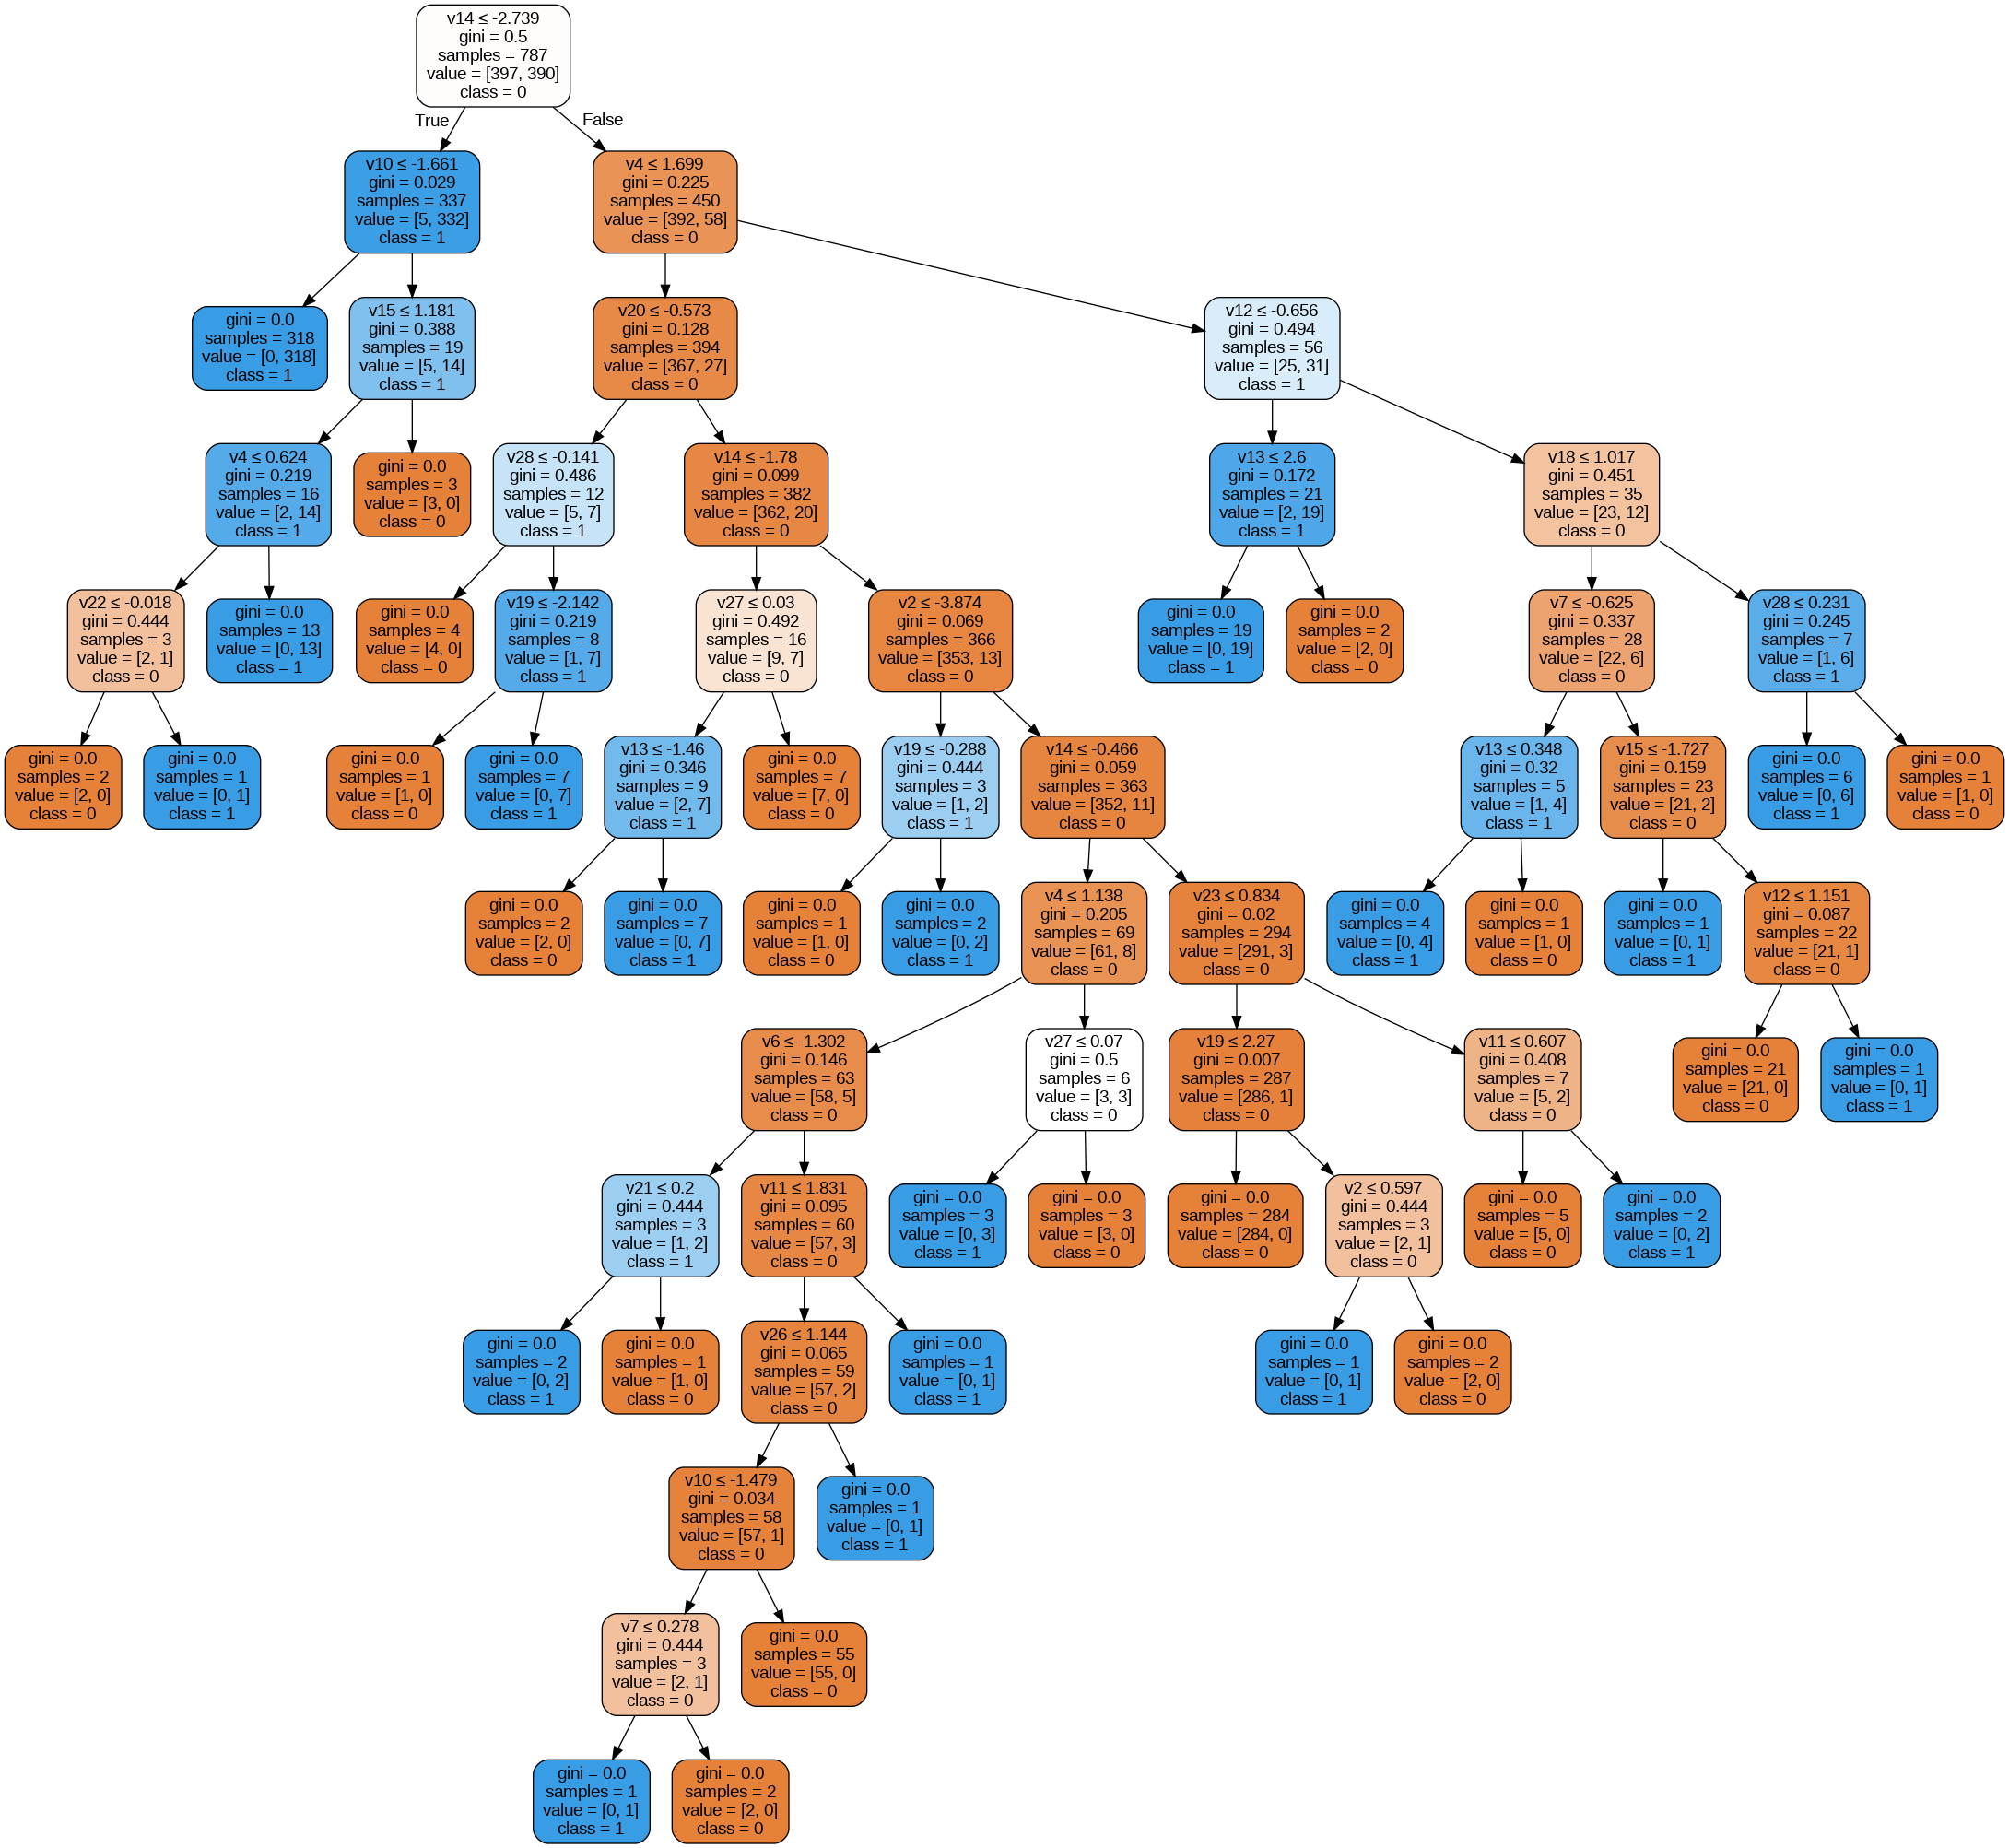

In [24]:
model = DecisionTreeClassifier()
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  filled=True, rounded=True, special_characters=True,
                feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(TMP_PATH+'dt.png')
Image(graph.create_png())

Accuracy: 0.8984771573604061
Precision: 0.9019607843137255
Recall: 0.9019607843137255


<Figure size 432x288 with 0 Axes>

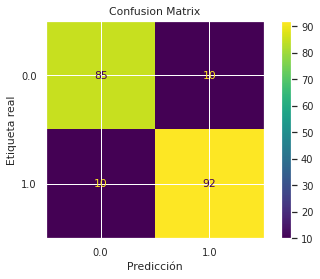

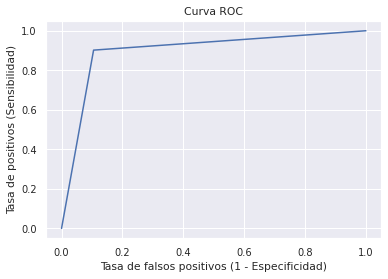

In [25]:
model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,"dt1.pkl")


##### 4.2 Modelo 2, con otros parámetros

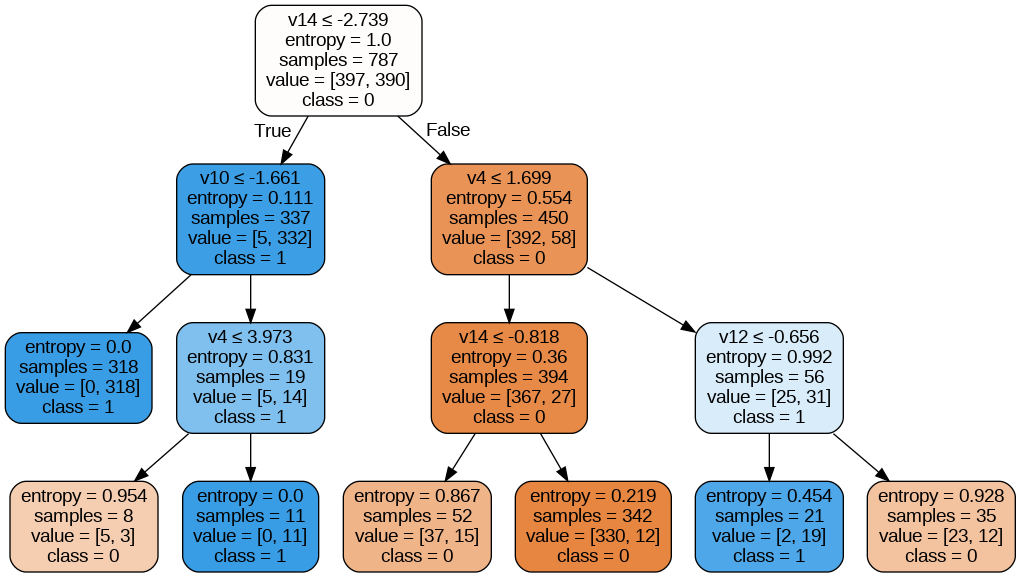

In [26]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=3)
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

dot_data = StringIO()
export_graphviz( model, out_file=dot_data,  filled=True, rounded=True, special_characters=True, 
                 feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(TMP_PATH+'dt_pruned.png')
Image(graph.create_png())

Accuracy: 0.8934010152284264
Precision: 0.9764705882352941
Recall: 0.8137254901960784


<Figure size 432x288 with 0 Axes>

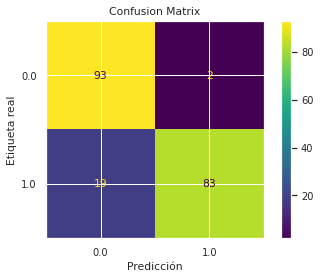

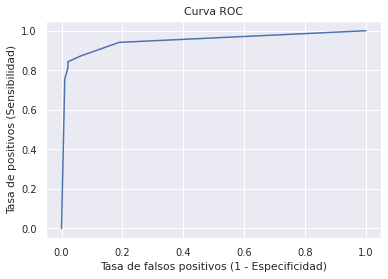

In [27]:
model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,"dt2.pkl")

#### 4.2 Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

Accuracy: 0.9137055837563451
Precision: 0.9775280898876404
Recall: 0.8529411764705882


<Figure size 432x288 with 0 Axes>

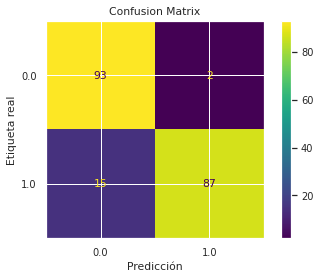

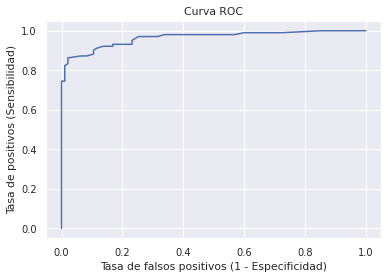

In [29]:
model=RandomForestClassifier(n_estimators=100)
model = model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,"rf1.pkl")

#### 4.4 Regresión Logística

Accuracy: 0.8578680203045685
Precision: 0.8303571428571429
Recall: 0.9117647058823529


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


<Figure size 432x288 with 0 Axes>

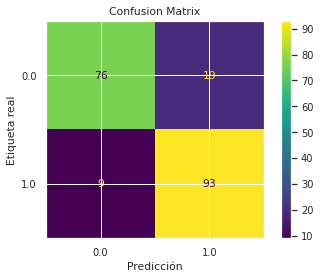

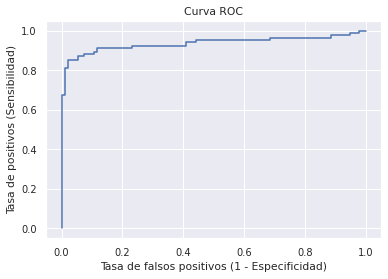

In [30]:
model = LogisticRegression(C=1, solver="sag", max_iter=1000)
model = model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,"lr1.pkl")

#### 3.5 SVM

Accuracy: 0.9035532994923858
Precision: 0.946236559139785
Recall: 0.8627450980392157


<Figure size 432x288 with 0 Axes>

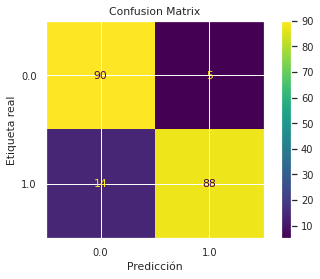

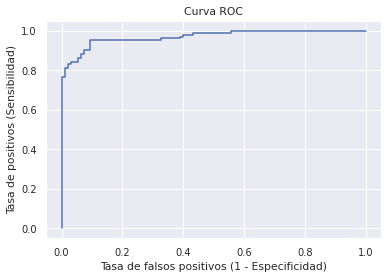

In [31]:
from sklearn import svm

model = svm.SVC(kernel='linear',probability=True) # Linear Kernel
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,"svm1.pkl")

### Comparación de resultados y conclusiones

In [32]:
# WIP

# WIP, pruebas
<hr>